In [1]:
import ccxt
import numpy as np
import pandas as pd
import datetime as dt
from dateutil import tz
import matplotlib.pyplot as plt

import json
import time
import os
import sys

In [2]:
src_path = '../src/'
sys.path.append(os.path.abspath(src_path))
import func_get
import func_signal
import func_backtest

In [3]:
start_ts = time.time()

In [4]:
interval_dict = {
    '1m': 1,
    '5m': 5,
    '15m': 15,
    '30m': 30,
    '1h': 60,
    '2h': 120,
    '4h': 240,
    '1d': 1440
}

In [5]:
with open('../../../_keys/ftx/ftx_read_keys.json') as keys_file:
    keys_dict = json.load(keys_file)
    
exchange = ccxt.ftx({'apiKey': keys_dict['apiKey'],
                     'secret': keys_dict['secret'],
                     'enableRateLimit': True})

### Config

In [6]:
project_name = 'cross'

In [7]:
start_date = dt.datetime(2022, 1, 1)
start_hour = 1
end_date = dt.datetime.today() - dt.timedelta(days=1)
reinvest_profit_flag = True

In [8]:
config_params = {
    'safety_ohlcv_range': 1000,
    'action_timeframe': '15m',
    'target_side': ['buy'],
    'base': {
        'symbol': ['ETH-PERP'],
        'open': {
            '15m': {
                'cross_sma': {
                    'check': ['check_signal_side_change'],
                    'look_back': 1,
                    'short_windows': 15,
                    'long_windows': 200,
                    'revert': False
                }
            }
        },
        'close': {
            '15m': {
                'cross_sma': {
                    'check': ['check_signal_side'],
                    'look_back': 1,
                    'short_windows': 15,
                    'long_windows': 200,
                    'revert': False
                }
            }
        }
    },
    'lead': {
        'symbol': [],
        'open': {
        },
        'close': {
        }
    },
    'tp': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None,
    },
    'sl': {
        'stop_percent': 100,
        'price_percent': None,
        'signal': None
    },
    'action_percent': 100,
    'leverage': 1,
    'taker_fee_percent': 0.07
}

### Get data

In [9]:
ohlcv_df_dict = func_get.get_data(exchange, start_date, end_date, start_hour, interval_dict, config_params)

base: timeframe 1/1 symbol 1/1 date 1/118
base: timeframe 1/1 symbol 1/1 date 2/118
base: timeframe 1/1 symbol 1/1 date 3/118
base: timeframe 1/1 symbol 1/1 date 4/118
base: timeframe 1/1 symbol 1/1 date 5/118
base: timeframe 1/1 symbol 1/1 date 6/118
base: timeframe 1/1 symbol 1/1 date 7/118
base: timeframe 1/1 symbol 1/1 date 8/118
base: timeframe 1/1 symbol 1/1 date 9/118
base: timeframe 1/1 symbol 1/1 date 10/118
base: timeframe 1/1 symbol 1/1 date 11/118
base: timeframe 1/1 symbol 1/1 date 12/118
base: timeframe 1/1 symbol 1/1 date 13/118
base: timeframe 1/1 symbol 1/1 date 14/118
base: timeframe 1/1 symbol 1/1 date 15/118
base: timeframe 1/1 symbol 1/1 date 16/118
base: timeframe 1/1 symbol 1/1 date 17/118
base: timeframe 1/1 symbol 1/1 date 18/118
base: timeframe 1/1 symbol 1/1 date 19/118
base: timeframe 1/1 symbol 1/1 date 20/118
base: timeframe 1/1 symbol 1/1 date 21/118
base: timeframe 1/1 symbol 1/1 date 22/118
base: timeframe 1/1 symbol 1/1 date 23/118
base: timeframe 1/1 

### Add signal

In [10]:
ohlcv_df_dict = func_signal.add_signal(start_date, ohlcv_df_dict, interval_dict, config_params)

base add cross_sma to ETH-PERP 15m
base add cross_sma to ETH-PERP 15m


### Back test

In [11]:
action_time_list = func_get.gen_action_time_list(config_params, ohlcv_df_dict)
max_open_timeframe = func_backtest.get_max_open_timeframe(config_params, interval_dict)

In [12]:
budget = 100

transaction_dict = {
    'symbol': [],
    'side': [],
    'amount': [],
    'open_time': [],
    'open_price': [],
    'close_time': [],
    'close_price': [],
    'value': [],
    'notional': [],
    'profit': [],
    'profit_percent': []
}

position_dict = {}

if reinvest_profit_flag == True:
    budget_dict = {
        'time': [],
        'budget': []
    }
    
max_drawdown = 0

In [13]:
if reinvest_profit_flag == True:
    min_budget = budget

time_count = 0

for signal_time in action_time_list:
    action_time = signal_time + dt.timedelta(minutes=interval_dict[config_params['action_timeframe']])
    
    time_count += 1
    print(f"Time {action_time}: progress {time_count}/{len(action_time_list)}")

    '''
    Close positions
    '''
    for symbol in [x for x in position_dict.keys()]:
        print(f"  {symbol}")
        budget, max_drawdown, position_dict, transaction_dict = func_backtest.close_position(symbol, signal_time, max_drawdown, config_params, budget, reinvest_profit_flag, ohlcv_df_dict, position_dict, transaction_dict, interval_dict)

    '''
    Open positions
    '''
    max_position = int(1 / (config_params['action_percent'] / 100))

    for symbol in [x for x in config_params['base']['symbol'] if x not in position_dict.keys()][:max_position]:
        print(f"  {symbol}")
        position_dict = func_backtest.open_position(symbol, signal_time, max_open_timeframe, config_params, budget, ohlcv_df_dict, position_dict, interval_dict)    
    
    '''
    Update budget
    '''
    if reinvest_profit_flag == True:
        budget_dict['time'].append(signal_time)
        budget_dict['budget'].append(budget)

        if budget < min_budget:
            min_budget = budget

    if budget <= 0:
        print(f"Out of money at {action_time}")
        break
        
'''
Clear final position
'''
opened_symbol = list(position_dict.keys())

for symbol in opened_symbol:
    print(f" Clear {symbol} position")
    
    side = position_dict[symbol]['side']
    ohlcv_df = ohlcv_df_dict['base'][config_params['action_timeframe']][symbol]
    current_ohlcv_df = ohlcv_df[ohlcv_df['time'] == signal_time].reset_index(drop=True)
    close_price = current_ohlcv_df.loc[0, 'close']
    close_percent = 100
    
    budget, position_dict, transaction_dict = func_backtest.update_close_position(symbol, side, close_price, close_percent, signal_time, config_params, budget, reinvest_profit_flag, position_dict, transaction_dict, interval_dict)

Time 2022-01-01 00:15:00: progress 1/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 00:30:00: progress 2/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 00:45:00: progress 3/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:00:00: progress 4/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:15:00: progress 5/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:30:00: progress 6/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 01:45:00: progress 7/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-01 02:00:00: progress

  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-04 06:15:00: progress 313/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-04 06:30:00: progress 314/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-04 06:45:00: progress 315/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-04 07:00:00: progress 316/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-04 07:15:00: progress 317/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-04 07:30:00: progress 318/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-04 07:45:00: progress 319/10276
  ETH-PERP
     base

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-06 23:15:00: progress 573/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-06 23:30:00: progress 574/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-06 23:45:00: progress 575/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-07 00:00:00: progress 576/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-07 00:15:00: progress 577/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-07 00:30:00: progress 578/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-07 00:45:00: progress 579/10276
  ETH-PERP
     base ETH-PERP c

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 08:30:00: progress 898/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 08:45:00: progress 899/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 09:00:00: progress 900/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 09:15:00: progress 901/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 09:30:00: progress 902/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 09:45:00: progress 903/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 10:00:00: progress 904/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-10 10:15:00: progress 905/1

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 19:45:00: progress 1135/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 20:00:00: progress 1136/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 20:15:00: progress 1137/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 20:30:00: progress 1138/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 20:45:00: progress 1139/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 21:00:00: progress 1140/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 21:15:00: progress 1141/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-12 21:30:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 05:45:00: progress 1367/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 06:00:00: progress 1368/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 06:15:00: progress 1369/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 06:30:00: progress 1370/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 06:45:00: progress 1371/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 07:00:00: progress 1372/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 07:15:00: progress 1373/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-15 07:30:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 11:15:00: progress 1581/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 11:30:00: progress 1582/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 11:45:00: progress 1583/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 12:00:00: progress 1584/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 12:15:00: progress 1585/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 12:30:00: progress 1586/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-17 12:45:00: progress 1587/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-20 10:00:00: progress 1864/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-20 10:15:00: progress 1865/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-20 10:30:00: progress 1866/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-20 10:45:00: progress 1867/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-20 11:00:00: progress 1868/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-20 11:15:00: progress 1869/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-20 11:30:00: progress 1870/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 12:15:00: progress 2161/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 12:30:00: progress 2162/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 12:45:00: progress 2163/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 13:00:00: progress 2164/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 13:15:00: progress 2165/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 13:30:00: progress 2166/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-23 13:45:00: progress 2167/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 10:00:00: progress 2440/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 10:15:00: progress 2441/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 10:30:00: progress 2442/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 10:45:00: progress 2443/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 11:00:00: progress 2444/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 11:15:00: progress 2445/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 11:30:00: progress 2446/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-26 11:45:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-28 21:45:00: progress 2679/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-28 22:00:00: progress 2680/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-28 22:15:00: progress 2681/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-28 22:30:00: progress 2682/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-28 22:45:00: progress 2683/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-28 23:00:00: progress 2684/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-28 23:15:00: progress 2685/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-01-31 05:00:00: progress 2900/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: sell
     Closed by signal at 2561.0
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: sell
     No action
Time 2022-01-31 05:15:00: progress 2901/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 05:30:00: progress 2902/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 05:45:00: progress 2903/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 06:00:00: progress 2904/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-01-31 06:15:00: progress 2905/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
   

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 15:30:00: progress 3134/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 15:45:00: progress 3135/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 16:00:00: progress 3136/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 16:15:00: progress 3137/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 16:30:00: progress 3138/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 16:45:00: progress 3139/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 17:00:00: progress 3140/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-02 17:15:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 02:15:00: progress 3369/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 02:30:00: progress 3370/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 02:45:00: progress 3371/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 03:00:00: progress 3372/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 03:15:00: progress 3373/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 03:30:00: progress 3374/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 03:45:00: progress 3375/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-05 04:00:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-07 02:30:00: progress 3562/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-07 02:45:00: progress 3563/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-07 03:00:00: progress 3564/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-07 03:15:00: progress 3565/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-07 03:30:00: progress 3566/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-07 03:45:00: progress 3567/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-07 04:00:00: progress 3568/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: sell
     Closed by signal at 3071.9
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: sell
     No action
Time 2022-02-08 22:15:00: progress 3737/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-08 22:30:00: progress 3738/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-08 22:45:00: progress 3739/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-08 23:00:00: progress 3740/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-08 23:15:00: progress 3741/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-08 23:30:00: progress 3742/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: 

Time 2022-02-11 01:30:00: progress 3942/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-11 01:45:00: progress 3943/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-11 02:00:00: progress 3944/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-11 02:15:00: progress 3945/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-11 02:30:00: progress 3946/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-11 02:45:00: progress 3947/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-11 03:00:00: progress 3948/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-11 03:15:00: progress 3949/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-13 20:45:00: progress 4211/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-13 21:00:00: progress 4212/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-13 21:15:00: progress 4213/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-13 21:30:00: progress 4214/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-13 21:45:00: progress 4215/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-13 22:00:00: progress 4216/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-13 22:15:00: progress 4217/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-15 23:45:00: progress 4415/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 00:00:00: progress 4416/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 00:15:00: progress 4417/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 00:30:00: progress 4418/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 00:45:00: progress 4419/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 01:00:00: progress 4420/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 01:15:00: progress 4421/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-16 01:30:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-18 00:45:00: progress 4611/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-18 01:00:00: progress 4612/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-18 01:15:00: progress 4613/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-18 01:30:00: progress 4614/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-18 01:45:00: progress 4615/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-18 02:00:00: progress 4616/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-18 02:15:00: progress 4617/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-20 10:15:00: progress 4841/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-20 10:30:00: progress 4842/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-20 10:45:00: progress 4843/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-20 11:00:00: progress 4844/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-20 11:15:00: progress 4845/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-20 11:30:00: progress 4846/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-20 11:45:00: progress 4847/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 14:30:00: progress 5146/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 14:45:00: progress 5147/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 15:00:00: progress 5148/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 15:15:00: progress 5149/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 15:30:00: progress 5150/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 15:45:00: progress 5151/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 16:00:00: progress 5152/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-23 16:15:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-25 14:30:00: progress 5338/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-25 14:45:00: progress 5339/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-25 15:00:00: progress 5340/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-25 15:15:00: progress 5341/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-25 15:30:00: progress 5342/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-25 15:45:00: progress 5343/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-25 16:00:00: progress 5344/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-02-25 16:15:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-27 13:30:00: progress 5526/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-27 13:45:00: progress 5527/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-27 14:00:00: progress 5528/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-27 14:15:00: progress 5529/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-27 14:30:00: progress 5530/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-27 14:45:00: progress 5531/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-02-27 15:00:00: progress 5532/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 15:45:00: progress 5727/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 16:00:00: progress 5728/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 16:15:00: progress 5729/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 16:30:00: progress 5730/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 16:45:00: progress 5731/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 17:00:00: progress 5732/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 17:15:00: progress 5733/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-01 17:30:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 10:45:00: progress 5899/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 11:00:00: progress 5900/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 11:15:00: progress 5901/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 11:30:00: progress 5902/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 11:45:00: progress 5903/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 12:00:00: progress 5904/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-03 12:15:00: progress 5905/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-06 10:30:00: progress 6186/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-06 10:45:00: progress 6187/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-06 11:00:00: progress 6188/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-06 11:15:00: progress 6189/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-06 11:30:00: progress 6190/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-06 11:45:00: progress 6191/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-06 12:00:00: progress 6192/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 20:00:00: progress 6416/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 20:15:00: progress 6417/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 20:30:00: progress 6418/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 20:45:00: progress 6419/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 21:00:00: progress 6420/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 21:15:00: progress 6421/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 21:30:00: progress 6422/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-08 21:45:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 20:30:00: progress 6610/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 20:45:00: progress 6611/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 21:00:00: progress 6612/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 21:15:00: progress 6613/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 21:30:00: progress 6614/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 21:45:00: progress 6615/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-10 22:00:00: progress 6616/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-13 01:00:00: progress 6820/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-13 01:15:00: progress 6821/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: buy
     buy: 0.034041194457662634
     price: 2589.3
     tp: inf
     sl: 0
Time 2022-03-13 01:30:00: progress 6822/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-13 01:45:00: progress 6823/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-13 02:00:00: progress 6824/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-13 02:15:00: progress 6825/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-13 02:30:00: progress 6826/10276
  ETH-PERP
     base ET

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 03:45:00: progress 7023/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 04:00:00: progress 7024/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 04:15:00: progress 7025/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 04:30:00: progress 7026/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 04:45:00: progress 7027/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 05:00:00: progress 7028/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-15 05:15:00: progress 7029/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 04:45:00: progress 7219/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 05:00:00: progress 7220/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 05:15:00: progress 7221/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 05:30:00: progress 7222/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 05:45:00: progress 7223/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 06:00:00: progress 7224/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 06:15:00: progress 7225/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-17 06:30:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 11:00:00: progress 7436/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 11:15:00: progress 7437/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 11:30:00: progress 7438/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 11:45:00: progress 7439/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 12:00:00: progress 7440/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 12:15:00: progress 7441/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 12:30:00: progress 7442/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-19 12:45:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 14:30:00: progress 7642/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 14:45:00: progress 7643/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 15:00:00: progress 7644/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 15:15:00: progress 7645/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 15:30:00: progress 7646/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 15:45:00: progress 7647/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-03-21 16:00:00: progress 7648/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 11:00:00: progress 7820/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 11:15:00: progress 7821/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 11:30:00: progress 7822/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 11:45:00: progress 7823/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 12:00:00: progress 7824/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 12:15:00: progress 7825/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 12:30:00: progress 7826/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-23 12:45:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 05:30:00: progress 7990/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 05:45:00: progress 7991/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 06:00:00: progress 7992/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 06:15:00: progress 7993/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 06:30:00: progress 7994/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 06:45:00: progress 7995/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 07:00:00: progress 7996/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-25 07:15:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 08:00:00: progress 8192/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 08:15:00: progress 8193/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 08:30:00: progress 8194/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 08:45:00: progress 8195/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 09:00:00: progress 8196/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 09:15:00: progress 8197/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 09:30:00: progress 8198/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-27 09:45:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 03:00:00: progress 8364/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 03:15:00: progress 8365/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 03:30:00: progress 8366/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 03:45:00: progress 8367/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 04:00:00: progress 8368/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 04:15:00: progress 8369/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 04:30:00: progress 8370/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-29 04:45:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-31 03:30:00: progress 8558/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-31 03:45:00: progress 8559/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-31 04:00:00: progress 8560/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-31 04:15:00: progress 8561/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-31 04:30:00: progress 8562/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-31 04:45:00: progress 8563/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-03-31 05:00:00: progress 8564/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: sell
     Closed by signal at 3389.3
  ETH-PERP
    

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 07:30:00: progress 8766/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 07:45:00: progress 8767/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 08:00:00: progress 8768/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 08:15:00: progress 8769/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 08:30:00: progress 8770/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 08:45:00: progress 8771/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 09:00:00: progress 8772/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-02 09:15:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 01:15:00: progress 8933/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 01:30:00: progress 8934/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 01:45:00: progress 8935/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 02:00:00: progress 8936/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 02:15:00: progress 8937/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 02:30:00: progress 8938/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 02:45:00: progress 8939/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-04 03:00:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 02:00:00: progress 9128/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 02:15:00: progress 9129/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 02:30:00: progress 9130/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 02:45:00: progress 9131/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 03:00:00: progress 9132/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 03:15:00: progress 9133/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-06 03:30:00: progress 9134/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-08 07:30:00: progress 9342/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-08 07:45:00: progress 9343/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-08 08:00:00: progress 9344/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-08 08:15:00: progress 9345/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-08 08:30:00: progress 9346/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-08 08:45:00: progress 9347/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-08 09:00:00: progress 9348/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 11:45:00: progress 9551/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 12:00:00: progress 9552/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 12:15:00: progress 9553/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 12:30:00: progress 9554/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 12:45:00: progress 9555/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 13:00:00: progress 9556/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 13:15:00: progress 9557/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-10 13:30:00: progres

     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-12 12:00:00: progress 9744/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-12 12:15:00: progress 9745/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-12 12:30:00: progress 9746/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-12 12:45:00: progress 9747/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-12 13:00:00: progress 9748/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-12 13:15:00: progress 9749/10276
  ETH-PERP
     base ETH-PERP check_signal_side_change cross_sma 15m: no_action
     No action
Time 2022-04-12 13:30:00: progress 9750/10276
  ETH-PERP
     base ETH

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-14 11:00:00: progress 9932/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-14 11:15:00: progress 9933/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-14 11:30:00: progress 9934/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-14 11:45:00: progress 9935/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-14 12:00:00: progress 9936/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-14 12:15:00: progress 9937/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-14 12:30:00: progress 9938/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-14 12:45:00: progres

     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-16 13:15:00: progress 10133/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-16 13:30:00: progress 10134/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-16 13:45:00: progress 10135/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-16 14:00:00: progress 10136/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-16 14:15:00: progress 10137/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-16 14:30:00: progress 10138/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-16 14:45:00: progress 10139/10276
  ETH-PERP
     base ETH-PERP check_signal_side cross_sma 15m: buy
     Not close
Time 2022-04-16 15:00:00: 

In [14]:
end_ts = time.time()
time_process = end_ts - start_ts
print(f"Time process: {round(time_process / 60, 2)} minutes")

Time process: 0.64 minutes


### Result

In [15]:
transaction_df = pd.DataFrame(transaction_dict)
transaction_df.to_csv(f'transactions/{project_name}.csv', index=False)
transaction_df

,symbol,side,amount,open_time,open_price,close_time,close_price,value,notional,profit,profit_percent
0,ETH-PERP,buy,0.026803,2022-01-01 10:45:00,3730.9,2022-01-01 12:00:00,3709.2,100.000000,100.000000,-0.721222,-0.720717
1,ETH-PERP,buy,0.026524,2022-01-01 13:15:00,3743.0,2022-01-01 13:30:00,3728.6,99.278778,99.278778,-0.520666,-0.524082
2,ETH-PERP,buy,0.026339,2022-01-02 01:30:00,3749.5,2022-01-04 01:15:00,3757.6,98.758112,98.758112,0.074935,0.075825
3,ETH-PERP,buy,0.025863,2022-01-04 18:30:00,3821.4,2022-01-06 02:00:00,3747.9,98.833047,98.833047,-2.037970,-2.060590
4,ETH-PERP,buy,0.030224,2022-01-10 02:30:00,3202.6,2022-01-10 19:15:00,3087.5,96.795077,96.795077,-3.611849,-3.728829
5,ETH-PERP,buy,0.029682,2022-01-11 15:15:00,3139.4,2022-01-11 19:00:00,3110.7,93.183228,93.183228,-0.981730,-1.052811
6,ETH-PERP,buy,0.029490,2022-01-11 19:30:00,3126.5,2022-01-14 01:30:00,3288.9,92.201498,92.201498,4.656794,5.047138
7,ETH-PERP,buy,0.029052,2022-01-15 05:00:00,3334.0,2022-01-17 10:15:00,3323.7,96.858292,96.858292,-0.434624,-0.448408
8,ETH-PERP,buy,0.030692,2022-01-20 14:15:00,3141.7,2022-01-21 06:30:00,3020.0,96.423668,96.423668,-3.867541,-4.008182
9,ETH-PERP,buy,0.037074,2022-01-24 07:30:00,2496.5,2022-01-24 12:15:00,2428.5,92.556127,92.556127,-2.648870,-2.859905


In [16]:
if reinvest_profit_flag == True:
    print(f"Final budget: {round(budget, 2)}")
else:
    print("Not reinvest profit")

Final budget: 91.37


In [17]:
if reinvest_profit_flag == True:
    return_percent = (budget_dict['budget'][-1] - budget_dict['budget'][0]) / budget_dict['budget'][0] * 100
    print(f"Return: {round(return_percent, 2)}%")
else:
    print("Not reinvest profit")

Return: -7.72%


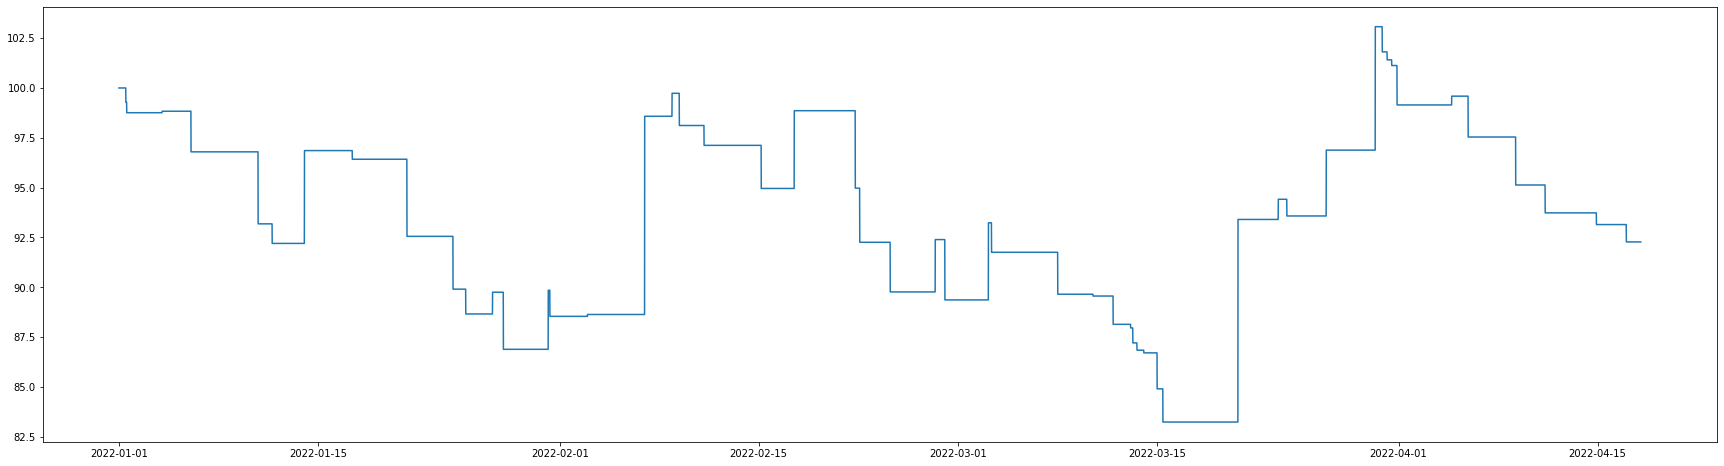

In [18]:
if reinvest_profit_flag == True:
    fig, ax = plt.subplots(figsize=(30, 8))
    ax.plot(budget_dict['time'], budget_dict['budget'])
else:
    print("Not reinvest profit")

In [19]:
if reinvest_profit_flag == True:
    print(f"Max drawdown: {round(max_drawdown * 100, 2)}%")

Max drawdown: 4.34%


In [20]:
win_rate = len(transaction_df[transaction_df['profit'] > 0]) / len(transaction_df)
print(f"Win rate: {round(win_rate * 100, 2)}%")

Win rate: 27.78%


In [21]:
for symbol in transaction_df['symbol'].unique():
    symbol_df = transaction_df[transaction_df['symbol'] == symbol]
    win_rate = len(symbol_df[symbol_df['profit'] > 0]) / len(symbol_df)
    print(f"{symbol} win rate: {round(win_rate * 100, 2)}%")

ETH-PERP win rate: 27.78%


In [22]:
print(f"Distribution")
print(pd.DataFrame(transaction_df['profit_percent'].describe()))

Distribution
       profit_percent
count       54.000000
mean        -0.116947
std          3.255642
min         -4.008182
25%         -2.032757
50%         -0.909849
75%          0.098347
max         12.199675


In [23]:
for symbol in transaction_df['symbol'].unique():
    temp_return = transaction_df[transaction_df['symbol'] == symbol]['profit_percent']
    
    print(f"Distribution {symbol}:")
    print(pd.DataFrame(temp_return.describe()))
    print("\n")

Distribution ETH-PERP:
       profit_percent
count       54.000000
mean        -0.116947
std          3.255642
min         -4.008182
25%         -2.032757
50%         -0.909849
75%          0.098347
max         12.199675




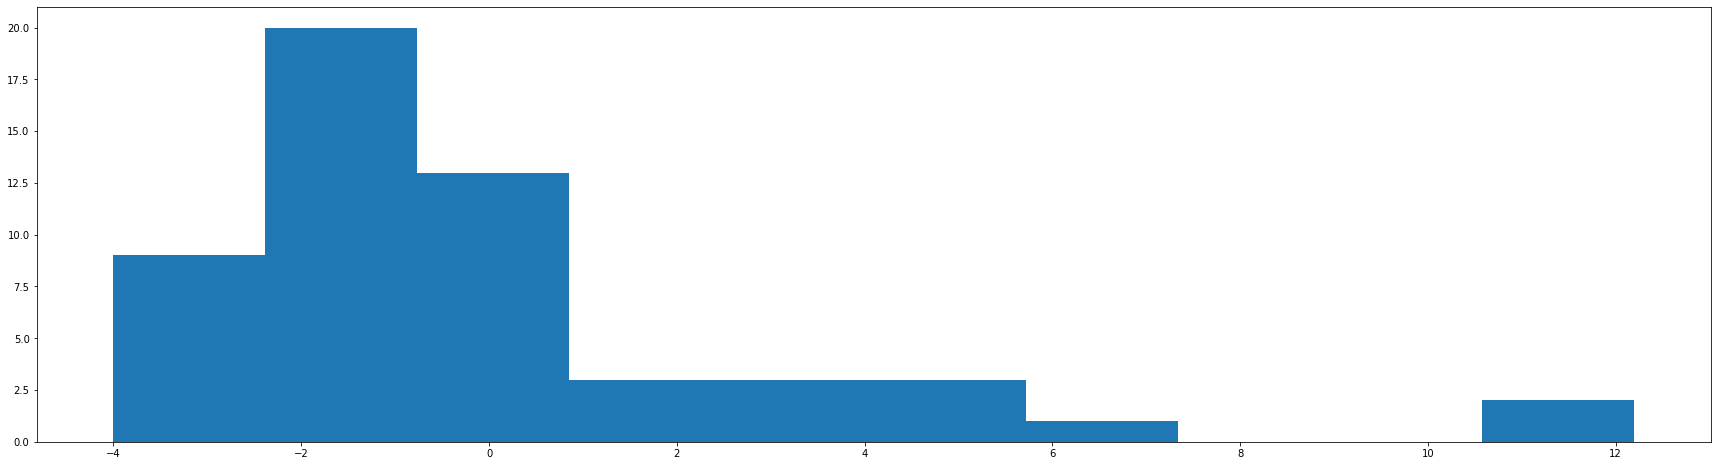

In [24]:
fig, ax = plt.subplots(figsize=(30, 8))
_ = ax.hist(transaction_df['profit_percent'], bins=10)